In [1]:
install.packages("tidyverse")
install.packages("tidymodels")
install.packages("themis")
install.packages("cowplot")
install.packages("ISLR")
install.packages("repr")
install.packages("GGally")
install.packages("themis")

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



In [2]:
install.packages("kknn")
#try not to run this cell its crashing for some reason

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



In [3]:
set.seed(1)

library(tidyverse)
library(tidymodels)
library(repr)
library(cowplot)
library(GGally)
library(ISLR)
library(themis)
options(repr.matrix.max.rows = 6)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 0.2.0 ──

✔ broom        0.7.12     ✔ rsample      0.1.1 
✔ dials        1.0.0      ✔ tune         0.2.0 
✔ infer        1.0.2      ✔ workflows    0.2.6 
✔ modeldata    0.1.1      ✔ workflowsets 0.2.1 
✔ parsnip      1.0.0      ✔ yardstick    1.0.0 
✔ recipes      0.2.0      

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filte

In [4]:
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip", temp)
pulsar_file <- unz(temp, "HTRU_2.csv")
pulsar <- read_csv(pulsar_file, col_names = FALSE)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
colnames(pulsar) <- c("mean_ip", "std_ip", "kurt_ip", "skew_ip", "mean_dm_snr", "std_dm_snr", "kurt_dm_snr", "skew_dm_snr", "class")

pulsar_mutate <- pulsar %>%
                mutate(class = as_factor(class))
pulsar_mutate

mean_ip,std_ip,kurt_ip,skew_ip,mean_dm_snr,std_dm_snr,kurt_dm_snr,skew_dm_snr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


In [6]:
# average of each column containing dbl values
pulsar_with_column_means <- pulsar %>%
                select(mean_ip:skew_dm_snr) %>%
                map_df(mean)
pulsar_with_column_means

mean_ip,std_ip,kurt_ip,skew_ip,mean_dm_snr,std_dm_snr,kurt_dm_snr,skew_dm_snr
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
111.08,46.54953,0.4778573,1.770279,12.6144,26.32651,8.303556,104.8577


In [7]:
pulsar_split <- initial_split(pulsar_mutate, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split) 
pulsar_test <- testing(pulsar_split)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



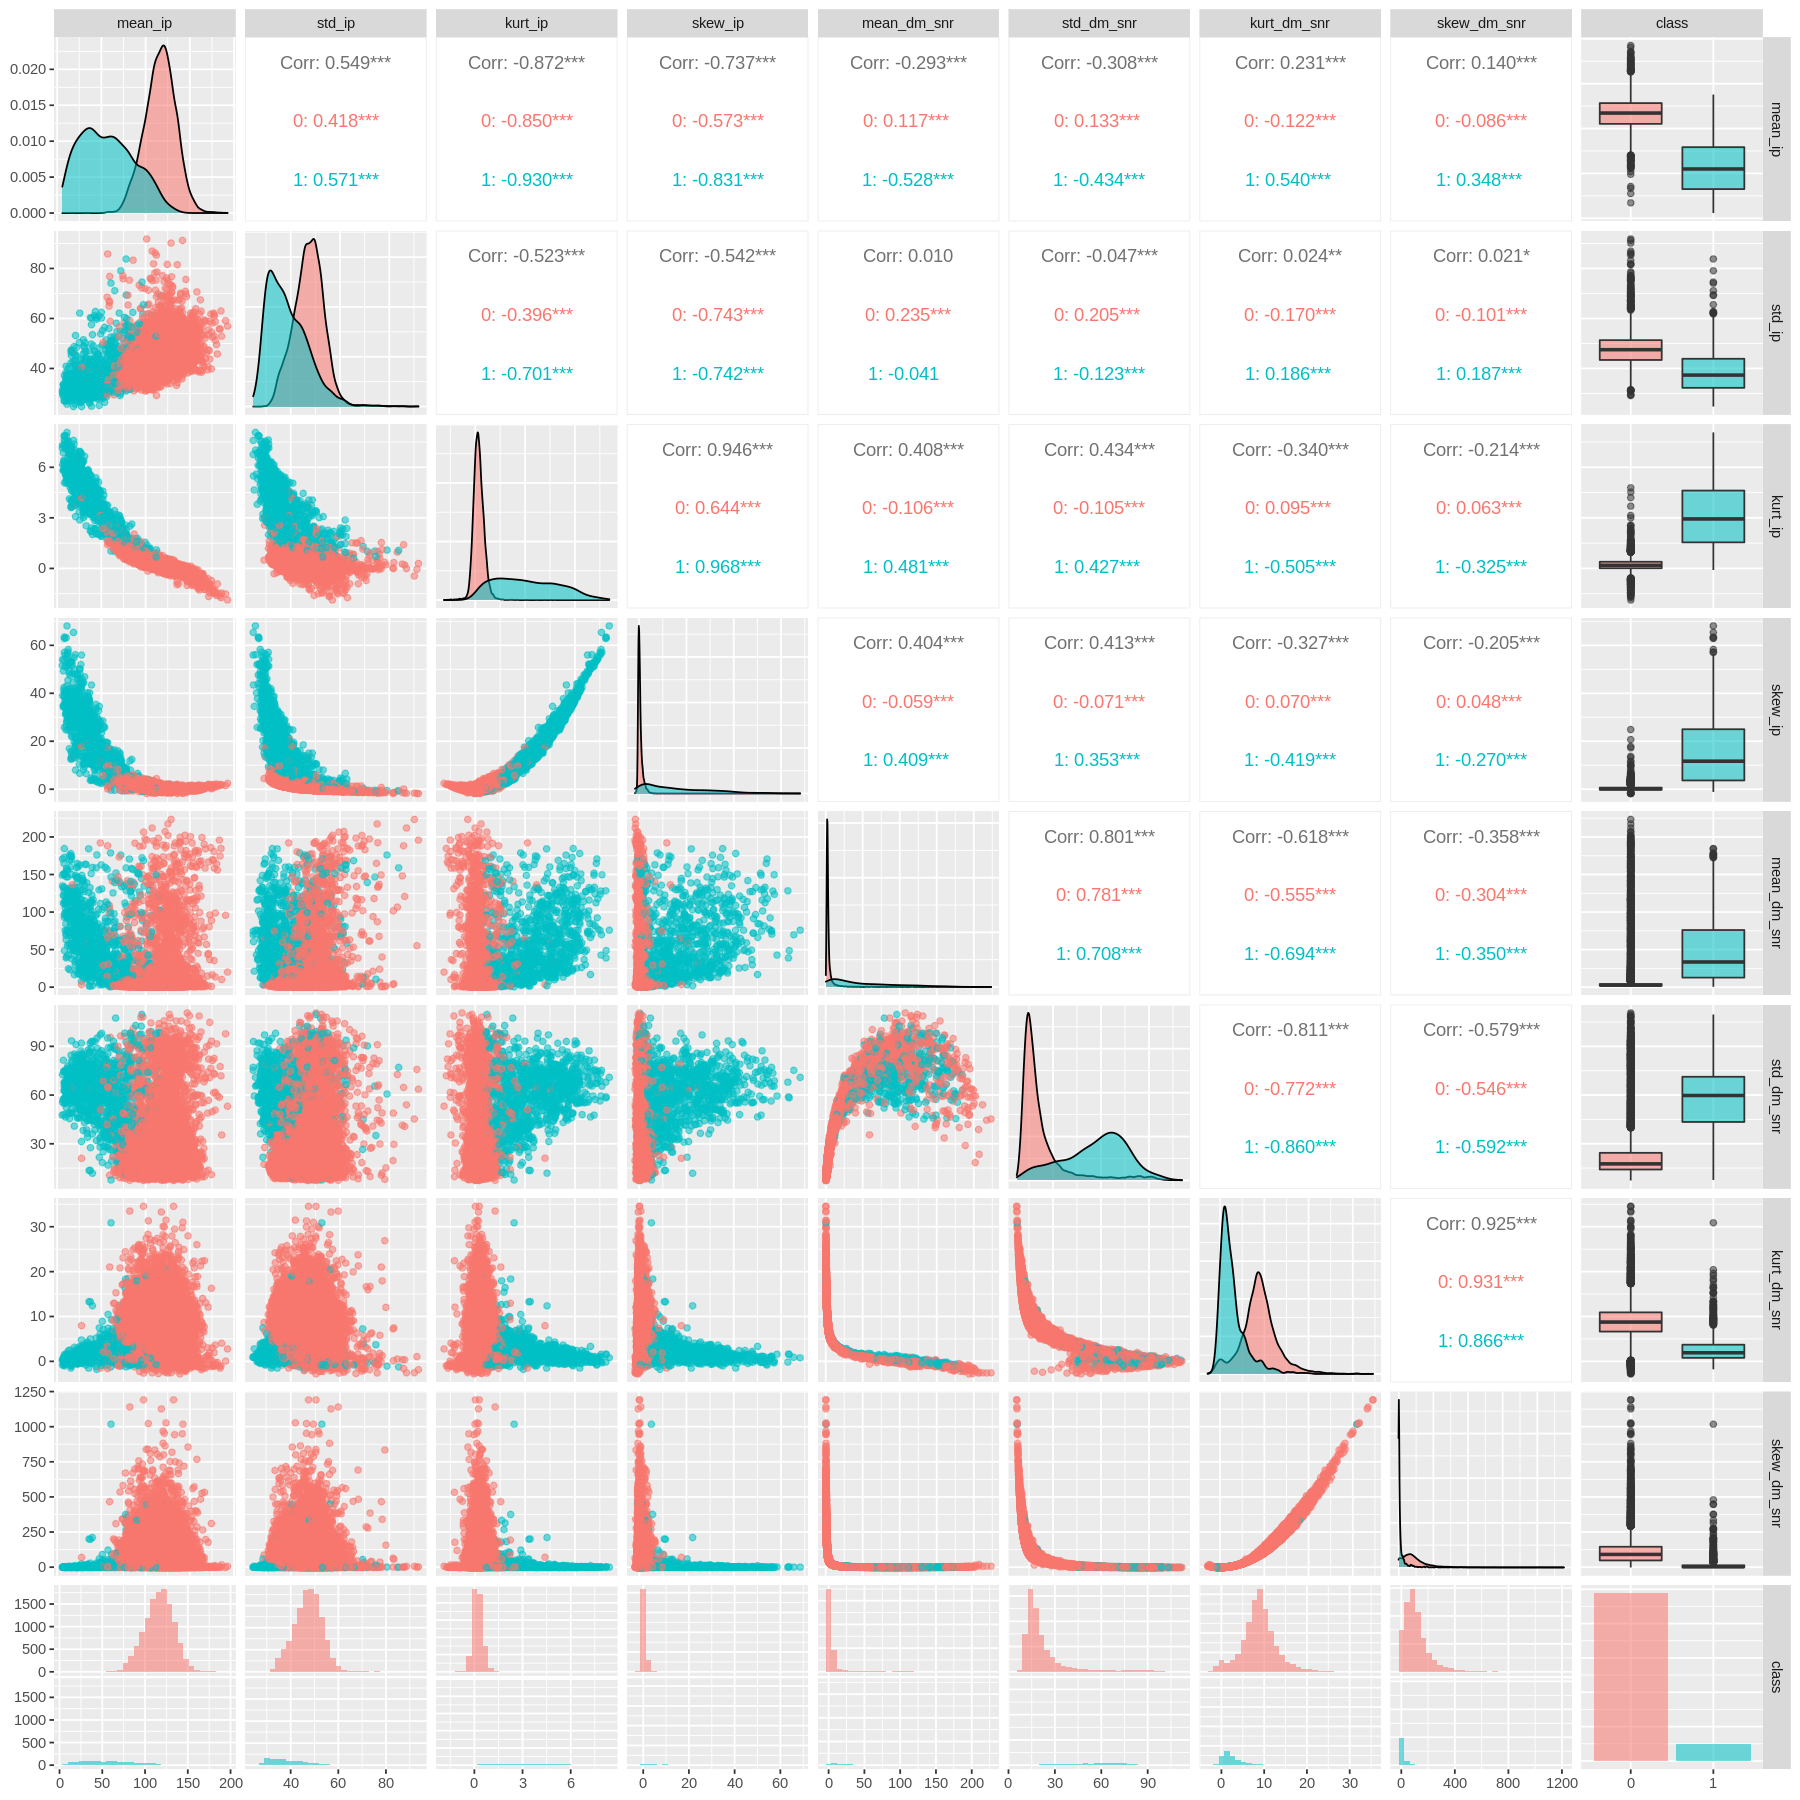

In [8]:
options(repr.plot.height = 15, repr.plot.width = 15)
correlation <- ggpairs(pulsar_train, mapping = aes(color = class, alpha = 0.5))
correlation
# options(repr.plot.height = 10, repr.plot.width = 10)
### all predictor variables can be used because there seems to be a cut off for each variable regarding the areas that factor 0 and 1 take up more or less 

In [10]:
sum(is.na(pulsar_train)) #checking for missing values in training data 

[1] 0

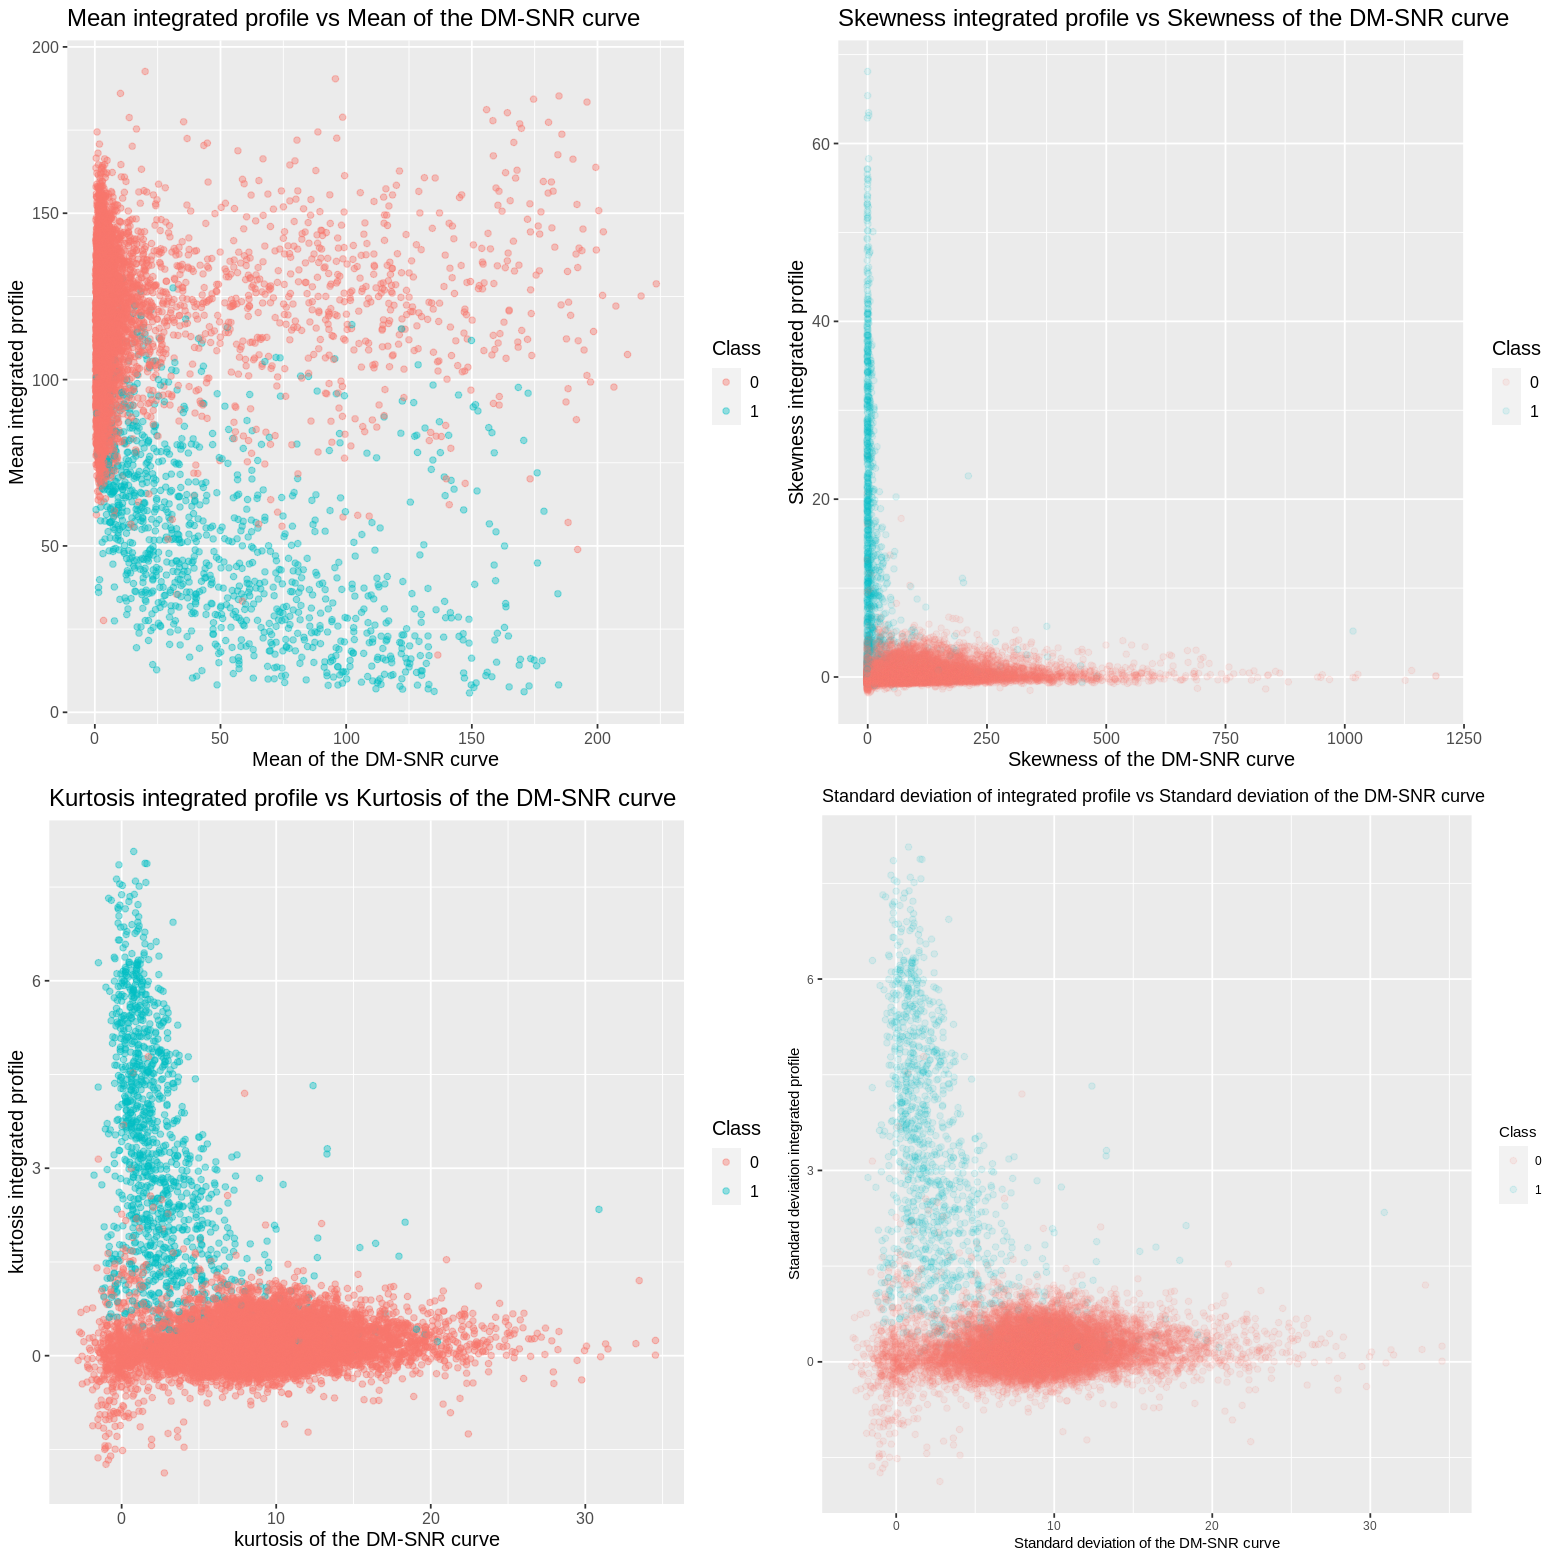

In [14]:
options(repr.plot.width = 13, repr.plot.height = 13)

plot_mean_ip_dmsnr <- ggplot(pulsar_train, aes(x = mean_dm_snr, y =mean_ip , color = class)) +
                geom_point(alpha = 0.4) +
                labs(x = "Mean of the DM-SNR curve", y = "Mean integrated profile", color = "Class") +
                theme(text = element_text(size = 12)) +
                ggtitle("Mean integrated profile vs Mean of the DM-SNR curve") 

plot_skew_ip_dmsnr <- ggplot(pulsar_train, aes(x = skew_dm_snr, y= skew_ip , color = class)) +
                geom_point(alpha = 0.1) +
                labs(x = "Skewness of the DM-SNR curve", y = "Skewness integrated profile", color = "Class") +
                theme(text = element_text(size = 12)) +
                ggtitle("Skewness integrated profile vs Skewness of the DM-SNR curve") 

plot_kurt_ip_dmsnr <- ggplot(pulsar_train, aes(x = kurt_dm_snr, y= kurt_ip , color = class)) +
                geom_point(alpha = 0.4) +
                labs(x = "kurtosis of the DM-SNR curve", y = "kurtosis integrated profile", color = "Class") +
                theme(text = element_text(size = 12)) +
                ggtitle("Kurtosis integrated profile vs Kurtosis of the DM-SNR curve") 

plot_std_ip_dmsnr <- ggplot(pulsar_train, aes(x = kurt_dm_snr, y= kurt_ip , color = class)) +
                geom_point(alpha = 0.1) +
                labs(x = "Standard deviation of the DM-SNR curve", y = "Standard deviation integrated profile", color = "Class") +
                theme(text = element_text(size = 9)) +
                ggtitle("Standard deviation of integrated profile vs Standard deviation of the DM-SNR curve") 

plot_grid(plot_mean_ip_dmsnr, plot_skew_ip_dmsnr, plot_kurt_ip_dmsnr, plot_std_ip_dmsnr, ncol = 2, nrow = 2)

In [11]:
#pulsar observation counts with 0's and 1's
# PULSAR OBSERVATION COUNTS FOR EACH CLASS 
# IT IS VERY IMBALANCED SO WE WILL HAVE TO USE STEP_UPSAMPLE TO BALANCE OUR CLASSES 
count_train_pulsar <- pulsar_train %>%
    group_by(class) %>%
    summarize(n = n())
count_train_pulsar

class,n
<fct>,<int>
0,12200
1,1223


In [16]:
### start data analysis = look for K 

In [131]:
# ACCOUNTING FOR ALL 8 PREDICTOR VARIABLES 
# RECIPE USES TRAINING DATA 
# DUE TO CLASS IMBALANCE, WE HAVE TO USE STEP_UPSAMPLE IN OUR RECIPE TO BALANCE OUR CLASSES 

pulsar_recipe <- recipe(class ~ kurt_ip + mean_dm_snr, data = pulsar_train) %>%
  step_downsample(class, under_ratio = 1, skip = TRUE) %>%   ### pass through to workflow = no bake; workflow does it for us 
  step_scale(all_predictors()) %>%
  step_center(all_predictors())
# step scale here 

downsampled_pulsar_train <- recipe(class ~ kurt_ip + mean_dm_snr, data = pulsar_train) %>%
  step_downsample(class, under_ratio = 1, skip = FALSE) %>%
    prep() %>%
    bake(pulsar_train)
downsampled_pulsar_train   ### recipe used for plotting, don't step scale here bc this for plotting

#DOUBLE CHECKING TO MAKE SURE THAT OUR CLASSES ARE NOW BALANCED (SAME COUNT FOR EACH CLASS) 

# downsampled_pulsar_train <- bake(pulsar_recipe, pulsar_train)

# downsampled_pulsar_train

# check <- downsampled_pulsar_train %>%
#   group_by(class) %>%
#   summarize(n = n())

# check

# MODEL SPEC TO DETERMINE K 
pulsar_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>% 
  set_engine("kknn") %>%
  set_mode("classification")

# USING CROSS-VALIDATION TO HELP US DETERMINE K 
# CHOSE V = 5 INSTEAD OF V=10 TO REDUCE RUN TIME 
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = class)


kurt_ip,mean_dm_snr,class
<dbl>,<dbl>,<fct>
0.4529505,0.9473244,0
-0.2532885,4.5418060,0
0.3491569,1.8152174,0
⋮,⋮,⋮
4.779124,129.8637,1
6.377273,141.8604,1
0.671724,149.8436,1


In [120]:
downsampled_pulsar_train

mean_ip,std_ip,kurt_ip,skew_ip,mean_dm_snr,std_dm_snr,kurt_dm_snr,skew_dm_snr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
111.5391,43.21872,0.3181562,0.10212085,2.336120,14.18856,9.821478,126.33907,0
116.9453,54.57668,0.2653007,-0.57501647,1.856187,12.43839,11.632629,181.43307,0
123.2734,49.44895,0.2119808,0.03391818,4.099498,18.71309,6.030657,46.74035,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
27.03906,33.75472,4.779124,26.2553572,129.8637,78.81544,-0.3484921,-0.8937907,1
28.37500,27.64931,6.377273,45.9440484,141.8604,82.89302,-0.4772223,-1.0678803,1
111.76562,52.94359,0.671724,0.3835939,149.8436,97.92695,-0.6961534,-1.2604028,1


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



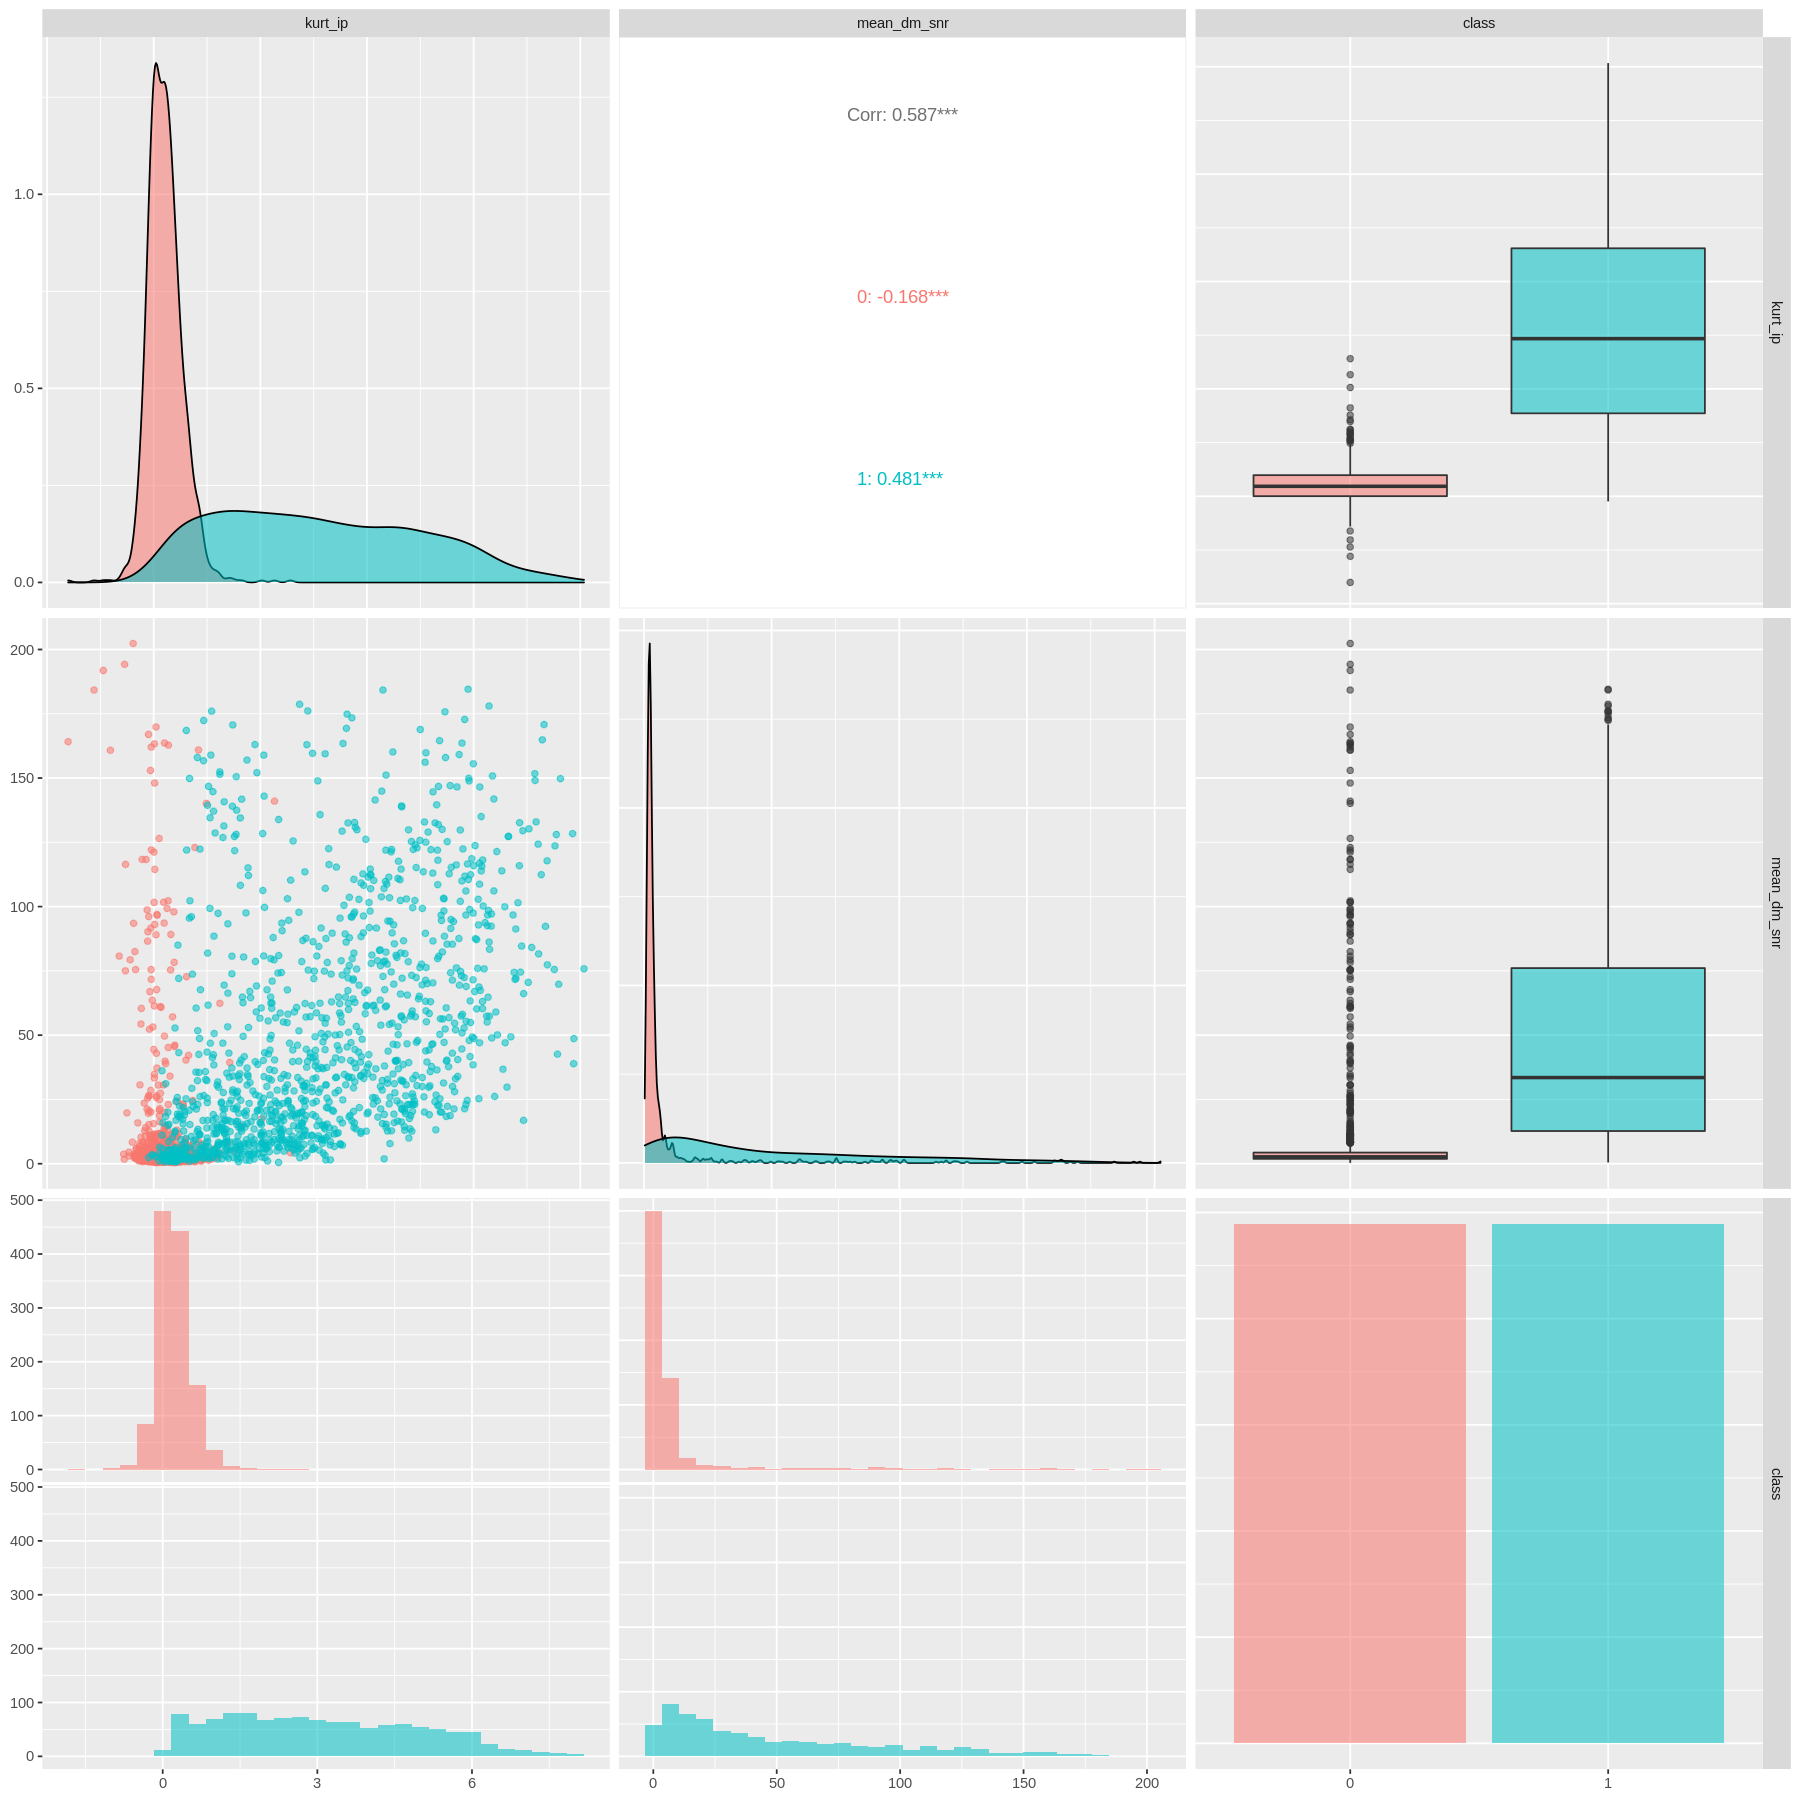

In [132]:
options(repr.plot.height = 15, repr.plot.width = 15)
correlation <- ggpairs(downsampled_pulsar_train, mapping = aes(color = class, alpha = 0.5))
correlation

In [ ]:
# WE ARE LOOKING AT K VALUES BETWEEN 1-15 
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# GETTING RESULTS FOR THE RECIPE, MODEL SPEC, AND CROSS-VALIDATION FROM ABOVE 
pulsar_results <- workflow() %>%
  add_recipe(pulsar_recipe) %>% # recipe
  add_model(pulsar_spec) %>% # model spec with tune()
  tune_grid(resamples = pulsar_vfold, grid = k_vals) %>%
    collect_metrics()

pulsar_results

# GETTING ACCURACIES SO WE CAN PLOT AN ACCURACY VS K PLOT TO DETERMINE OUR IDEAL K 
accuracies <- pulsar_results %>%
  filter(.metric == "accuracy")

accuracies

# PLOTTING ACCURACY VS K 
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

# accuracy_vs_k


In [ ]:
accuracy_for_4 <- accuracies %>%
        filter(neighbors == 4)
accuracy_for_4

In [ ]:
pulsar_final_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = 4) %>% 
  set_engine("kknn") %>%
  set_mode("classification")
                                      
pulsar_final_fit <- workflow() %>%
    add_recipe(pulsar_recipe) %>% 
    add_model(pulsar_final_spec) %>% 
    fit(data = pulsar_train)

prediction <- predict(pulsar_final_fit, pulsar_test) %>%
    bind_cols(pulsar_test)

prediction


test_set_accuracy <- prediction %>% # predictions object  
  metrics(truth = class, estimate = .pred_class) %>% # cat. variable
  filter(.metric == "accuracy") %>% # gives estimated accuracy %
  select(.estimate) %>% # for returning of only one value
  pull() # return only one value 

test_set_accuracy
                                      